In [6]:
# pip install ultralytics

In [7]:
# %% [markdown]
# Environment Check

import os, torch

print("Current directory:", os.getcwd())
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

Current directory: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src
PyTorch: 2.9.1
MPS available: True


'mps'

In [8]:
# %%
yaml_path = "../dataset/dataset.yaml"

yaml_text = """
path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print(open(yaml_path).read())

path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor


Visual sanity test

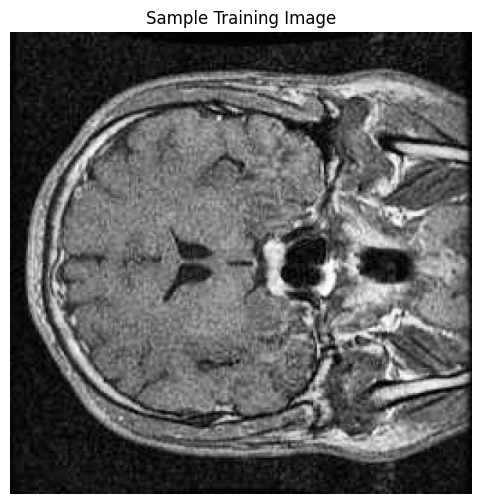

In [9]:
# %%
import json, cv2, random
import matplotlib.pyplot as plt

ann_file = "../dataset/train/_annotations.coco.json"
with open(ann_file, "r") as f:
    coco = json.load(f)

sample = random.choice(coco["images"])
filename = sample["file_name"]
img_path = f"../dataset/train/images/{filename}"

img = cv2.imread(img_path)
assert img is not None, img_path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Sample Training Image")
plt.axis("off")
plt.show()

Convert COCO → YOLO

In [10]:
# %% [markdown]
# COCO → YOLOv8 segmentation label converter (bbox → polygon)

import json, os
import numpy as np

def coco_bbox_to_polygon(x, y, w, h):
    """Return polygon list: 8 values (x1,y1,x2,y2,x3,y3,x4,y4)."""
    return [
        x,     y,
        x+w,   y,
        x+w,   y+h,
        x,     y+h
    ]

def convert_coco_to_yoloseg(coco_path, img_dir, label_dir):
    os.makedirs(label_dir, exist_ok=True)

    coco = json.load(open(coco_path))

    images = {img["id"]: img for img in coco["images"]}
    anns_by_img = {}

    for ann in coco["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    count = 0
    for img_id, img_info in images.items():
        fname = img_info["file_name"]
        w, h = img_info["width"], img_info["height"]

        label_path = os.path.join(label_dir, fname.rsplit(".",1)[0] + ".txt")

        with open(label_path, "w") as f:
            for ann in anns_by_img.get(img_id, []):
                # force class = 0 (tumor)
                cls = 0
                
                x, y, bw, bh = ann["bbox"]
                polygon = coco_bbox_to_polygon(x, y, bw, bh)
                
                # normalize
                poly_norm = []
                for i in range(0, len(polygon), 2):
                    xx = polygon[i]   / w
                    yy = polygon[i+1] / h
                    poly_norm.extend([xx, yy])

                line = str(cls) + " " + " ".join(f"{v:.6f}" for v in poly_norm)
                f.write(line + "\n")

        count += 1

    print(f"Converted {count} images → {label_dir}")

Conversion:

In [11]:
# %% [markdown]
# Convert train + valid

root = "../dataset"

convert_coco_to_yoloseg(
    f"{root}/train/_annotations.coco.json",
    f"{root}/train/images",
    f"{root}/train/labels"
)

convert_coco_to_yoloseg(
    f"{root}/valid/_annotations.coco.json",
    f"{root}/valid/images",
    f"{root}/valid/labels"
)

os.makedirs(f"{root}/test/labels", exist_ok=True)
print("Test labels prepared (empty).")

Converted 1502 images → ../dataset/train/labels
Converted 429 images → ../dataset/valid/labels
Test labels prepared (empty).


Clear Cache:

In [12]:
# %% [markdown]
# Clear any stale YOLO cache

import glob
for cache in glob.glob("../dataset/**/*.cache", recursive=True):
    print("Deleting:", cache)
    os.remove(cache)

Clean corrupted labels

In [13]:
train_images = "../dataset/train/images"
train_labels = "../dataset/train/labels"

deleted = 0

for txt in os.listdir(train_labels):
    if not txt.endswith(".txt"):
        continue
    base = txt[:-4]

    candidates = [base + ext for ext in [".jpg",".jpeg",".png"]]

    exists = any(os.path.exists(os.path.join(train_images, c)) for c in candidates)
    if not exists:
        os.remove(os.path.join(train_labels, txt))
        deleted += 1

print("Deleted corrupted labels:", deleted)

Deleted corrupted labels: 0


Train YOLOv8s (correct dirs)

In [ ]:
# %% [markdown]
# Train YOLOv8-seg

from ultralytics import YOLO

model = YOLO("yolov8s-seg.pt")

results = model.train(
    data="../dataset/dataset.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device=device,
    project="../experiments",
    name="yolo_seg_run1",
    save=True,
    save_period=1,
)

print("Training complete → ../experiments/yolo_seg_run1")

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_seg_run13, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       1/30      4.42G      1.919     0.5938      2.999      1.918         14        640: 100% ━━━━━━━━━━━━ 188/188 1.3s/it 4:091.4ss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/27 34.7s/it 10.4s<15:03WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 7% ╸─────────── 2/27 12.6s/it 15.5s<5:15WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 44% ━━━━━─────── 12/27 4.7s/it 1:03<1:108WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 48% ━━━━━╸────── 13/27 4.7s/it 1:08<1:06

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       2/30       4.5G      1.927    0.01496      2.219      1.915          8        640: 100% ━━━━━━━━━━━━ 188/188 1.4s/it 4:211.2ss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/27 21.7s/it 6.5s<9:25WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 7% ╸─────────── 2/27 15.7s/it 16.0s<6:32WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 11% ━─────────── 3/27 11.7s/it 23.4s<4:41WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 19% ━━────────── 5/27 7.7s/it 35.2s<2:49WA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       3/30      4.54G      1.904   0.004638      2.047      1.895          8        640: 100% ━━━━━━━━━━━━ 188/188 1.2s/it 3:541.4ss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/27 19.4s/it 5.8s<8:24WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 11% ━─────────── 3/27 10.6s/it 21.0s<4:15WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 15% ━╸────────── 4/27 7.7s/it 25.7s<2:57WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 19% ━━────────── 5/27 6.9s/it 31.3s<2:33WA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: divide by zero encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: overflow encountered in matmul
  xy = xy @ M.T  # transform
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ultralytics/data/augment.py:1181: RuntimeWarning: invalid value encountered in matmul
  xy = xy @ M.T  # transform


       4/30      4.51G      1.849   0.001045      1.973      1.858          9        640: 100% ━━━━━━━━━━━━ 188/188 2.2s/it 6:503.0ss
WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/27 31.7s/it 9.5s<13:45WARNING ⚠️ NMS time limit 2.800s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 7% ╸─────────── 2/27 19.0s/it 19.3s<7:54WARNING ⚠️ NMS time limit 2.800s exceeded


In [ ]:
# %% [markdown]
# Train YOLOv8-seg

from ultralytics import YOLO

model = YOLO("yolov8s-seg.pt")

results = model.train(
    data="../dataset/dataset.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device=device,
    project="../experiments",
    name="yolo_seg_run1",
    save=True,
    
    # FIXES for bbox→polygon synthetic masks
    hsv=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
    flipud=0.0,
    fliplr=0.5,   # horizontal flip ONLY (safe)
    mosaic=0.0,
)

print("Training complete → ../experiments/yolo_seg_run1")

Evaluate model (mIoU + Pixel Accuracy)


0: 640x640 1 tumor, 59.0ms
Speed: 0.8ms preprocess, 59.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


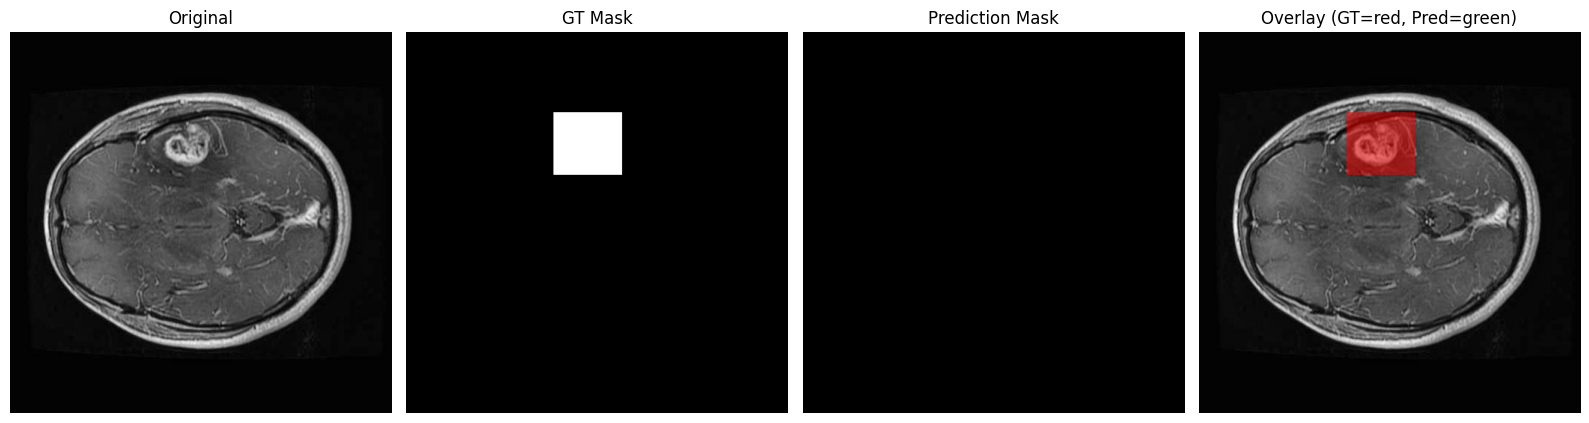


0: 640x640 1 tumor, 60.0ms
Speed: 0.8ms preprocess, 60.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


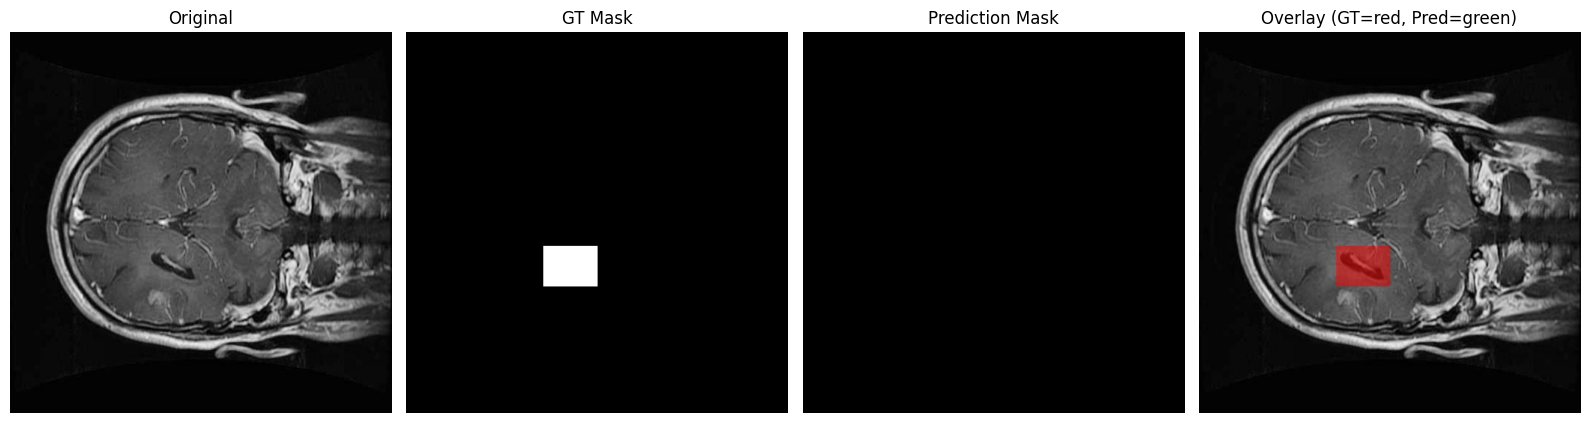


0: 640x640 2 tumors, 51.5ms
Speed: 0.7ms preprocess, 51.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


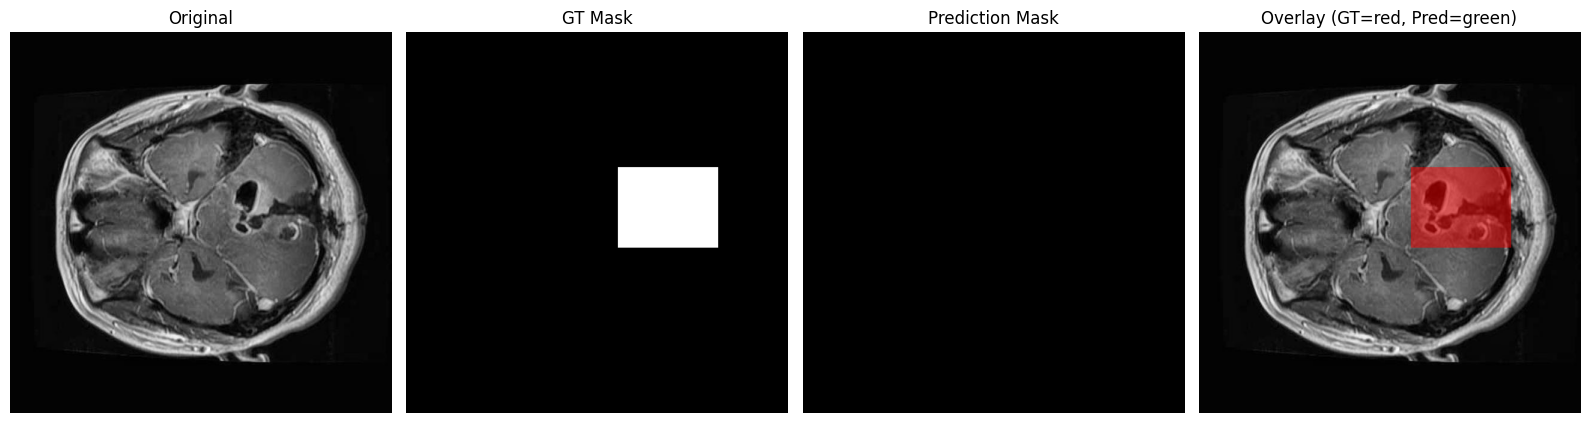


0: 640x640 2 tumors, 50.4ms
Speed: 0.7ms preprocess, 50.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


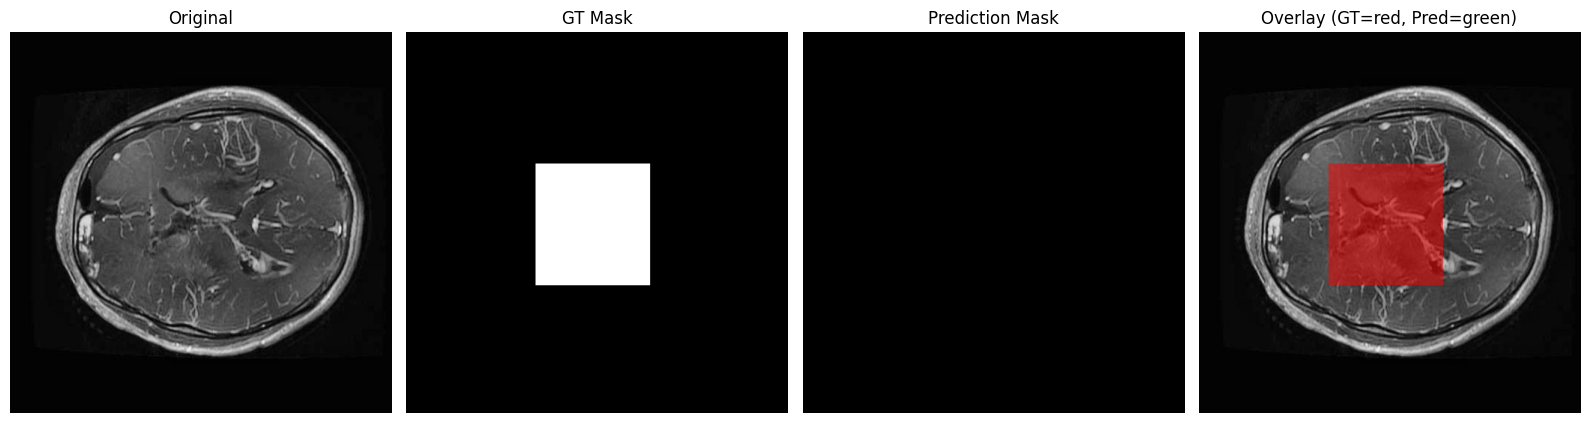

In [ ]:
# %% [markdown]
# Evaluate model (IoU, Pixel Accuracy, mAP)

from ultralytics import YOLO
model = YOLO("../experiments/yolo_seg_run1/weights/best.pt")

metrics = model.val(split="val")

print("Mask mAP50-95:", metrics.seg.map)
print("Mask mAP50:",    metrics.seg.map50)
print("Mask Precision:", metrics.seg.mp)
print("Mask Recall:",    metrics.seg.mr)
print("F1:",             metrics.seg.f1)

Automated Per-Image IoU (SEGMENTATION)

In [ ]:
# %% [markdown]
# Pixel-wise IoU and Accuracy

import cv2
import numpy as np
from tqdm import tqdm
import json

with open("../dataset/valid/_annotations.coco.json") as f:
    coco = json.load(f)

img_meta = {img["file_name"]: img for img in coco["images"]}

def box_to_mask(img_w, img_h, bbox):
    x,y,w,h = bbox
    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    mask[int(y):int(y+h), int(x):int(x+w)] = 1
    return mask


def compute_metrics(model):
    total_iou = 0
    total_acc = 0
    n = 0

    for img in tqdm(coco["images"]):
        fn = img["file_name"]
        w, h = img["width"], img["height"]

        img_path = f"../dataset/valid/images/{fn}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create GT mask from bbox
        anns = [a for a in coco["annotations"] if a["image_id"] == img["id"]]
        gt = np.zeros((h, w), dtype=np.uint8)
        for ann in anns:
            gt |= box_to_mask(w, h, ann["bbox"])

        # Prediction
        pred = model(image)[0]
        pmask = np.zeros((h, w), dtype=np.uint8)
        if pred.masks is not None:
            for m in pred.masks.data:
                m = cv2.resize(m.cpu().numpy(), (w, h))
                pmask |= (m > 0.5).astype(np.uint8)

        # IoU
        inter = np.logical_and(pmask, gt).sum()
        union = np.logical_or(pmask, gt).sum()
        iou = inter / (union + 1e-6)

        # Accuracy
        acc = (pmask == gt).mean()

        total_iou += iou
        total_acc += acc
        n += 1

    return total_iou / n, total_acc / n

model = YOLO("../experiments/yolo_seg_run1/weights/best.pt")
mean_iou, mean_acc = compute_metrics(model)

print("Pixel IoU:", mean_iou)
print("Pixel Accuracy:", mean_acc)

Visualization (GT vs Prediction Overlay)

In [ ]:
# %% [markdown]
# Visualization: GT vs Prediction Overlay

import matplotlib.pyplot as plt
import random

model = YOLO("../experiments/yolo_seg_run1/weights/best.pt")

sample = random.choice(coco["images"])
fn = sample["file_name"]
w, h = sample["width"], sample["height"]

img = cv2.imread(f"../dataset/valid/images/{fn}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# GT mask
anns = [a for a in coco["annotations"] if a["image_id"] == sample["id"]]
gt = np.zeros((h, w), dtype=np.uint8)
for ann in anns:
    gt |= box_to_mask(w, h, ann["bbox"])

# Prediction
pred = model(img)[0]
pmask = np.zeros((h, w), dtype=np.uint8)
if pred.masks is not None:
    for m in pred.masks.data:
        m = cv2.resize(m.cpu().numpy(), (w, h))
        pmask |= (m > 0.5).astype(np.uint8)

plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gt, cmap="gray"); plt.title("GT Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pmask, cmap="gray"); plt.title("Pred Mask"); plt.axis("off")
plt.show()

Generate submission masks for TEST set

In [ ]:
# # %% [markdown]
# # Predict on test set and write YOLO-Seg labels to dataset/test/labels

# test_dir = "../dataset/test/images"
# save_dir = "../dataset/test/labels"

# model = YOLO("../experiments/yolo_seg_run1/weights/best.pt")

# for fname in os.listdir(test_dir):
#     if not fname.lower().endswith((".jpg",".png",".jpeg")):
#         continue

#     img_path = os.path.join(test_dir, fname)
#     pred = model(img_path)[0]

#     out_path = os.path.join(save_dir, fname.rsplit(".",1)[0] + ".txt")

#     with open(out_path, "w") as f:
#         if pred.masks is None:
#             continue

#         for mask in pred.masks.xy:
#             flat = mask.reshape(-1)
#             f.write("0 " + " ".join(str(round(v,6)) for v in flat) + "\n")

# print("DONE — Predictions saved to test/labels/")